# Finding Donors for CharityML

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features.

In [3]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display
%matplotlib inline

# Import supplementary visualization code visuals.py
import visuals as vs

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head())

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group as well as the percentage of these individuals whos income is over $50,000.

In [4]:
# Total number of records
n_records = len(data)

# Number of records where individual's income is more than $50,000
n_over50k = len(data[data.income=='>50K'])

# Number of records where individual's income is at most $50,000
n_under50k = len(data[data.income=='<=50K'])

# Percentage of individuals whose income is more than $50,000
over50k_percent = round(n_over50k/n_records * 100, 2)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_over50k))
print("Individuals making at most $50,000: {}".format(n_under50k))
print("Percentage of individuals making more than $50,000: {}%".format(over50k_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


### Feature Exploration
- **age**: continuous.
- **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, - 10th, Doctorate, 5th-6th, Preschool.
- **education-num**: continuous.
- **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other.
- **sex**: Female, Male.
- **capital-gain**: continuous.
- **capital-loss**: continuous.
- **hours-per-week**: continuous.
- **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
---

## Preparing the Data
### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: `'capital-gain'` and `'capital-loss'`.

A histogram of these two features is plotted to note the range of the values present and how they are distributed.

C:\Users\emman\Documents\GitHub\MachineLearning\FindingDonorsProject\visuals.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


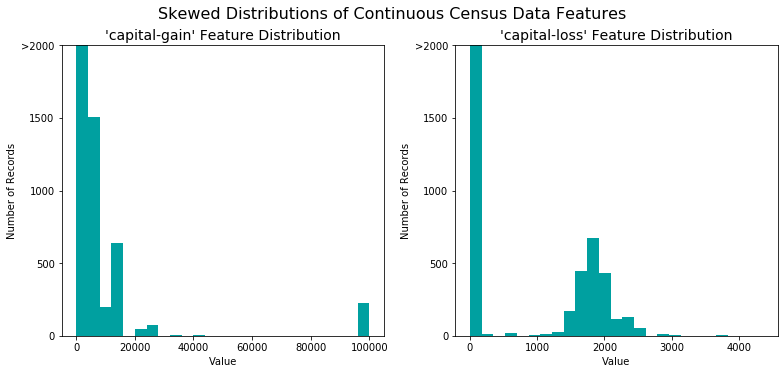

In [5]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a [logarithmic transformation](https://en.wikipedia.org/wiki/Data_transformation_(statistics)) on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of 0 is undefined, so we must translate the values by a small amount above 0 to apply the the logarithm successfully.

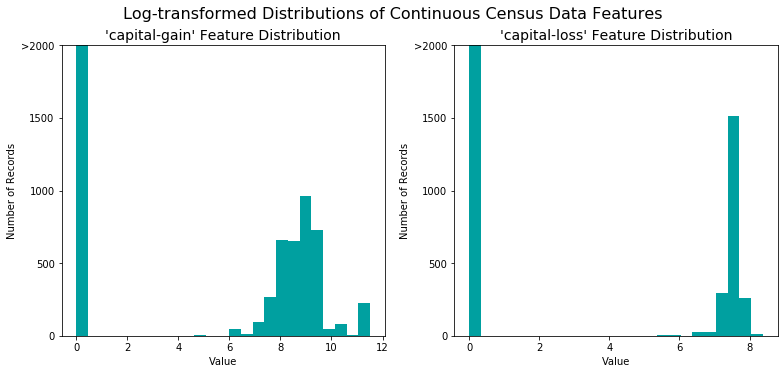

In [6]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

In [7]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head())

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Processing
From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called categorical variables) be converted. One popular way to convert categorical variables is by using the one-hot encoding scheme. **One-hot encoding** creates a *"dummy"* variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: A, B, or C. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

| | someFeature | | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: | :-: | :-: | :-: | :-: |
| 0 | B | | 0 | 1 | 0 |
| 1 | C | ---> one-hot encode ---> | 0 | 0 | 1 |
| 2 | A | | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as 0 and 1, respectively.

In [8]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 1 if x=='>50K' else 0)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
# print(encoded)

103 total features after one-hot encoding.


### Shuffle and Split data
Now all categorical variables have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [9]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


---
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
CharityML, equipped with their research, knows individuals that make more than 50k are most likely to donate to their charity. Because of this, they are particularly interested in predicting who makes more than 50k accurately. It would seem that using accuracy as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that does not make more than 50k as someone who does would be detrimental, since we are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than 50k is more important than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:



In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the F$_{0.5}$ score (or F-score for simplicity).

Looking at the distribution of classes (those who make at most 50k, and those who make more), it's clear most individuals do not make more than 50k. This can greatly affect accuracy, since we could simply say "this person does not make more than 50k and generally be right, without ever looking at the data! Making such a statement would be called naive, since we have not considered any information to substantiate the claim. It is always important to consider the naive prediction for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than 50k, CharityML would identify no one as donors.

**Note: Recap of accuracy, precision, and recall**

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points). 

**Precision** tells us what proportion of messages we classified as spam, actually were spam. It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of `[True Positives/(True Positives + False Positives)]`

**Recall** tells us what proportion of messages that actually were spam were classified by us as spam. It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of `[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Q1 - Naive Predictor Performance
- If we chose a model that always predicted an individual made more than 50k, what would that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

**Please note** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

- When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total.
- Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [10]:
TP = np.sum(income) # Counting the ones as this is the naive case.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = TP/income.count()
recall = TP/(TP + FN)
precision = TP/(TP + FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1 + beta**2) * (precision * recall)/(beta**2*precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### Supervised Learning Models
**Examples:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Q2 - Model Application
List three of the supervised learning models that are appropriate for this problem that you will test on the census data. For each model chosen
- Describe one real-world application in industry where the model can be applied.
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answers:**
- Real-world application: Document/Text Classification - Determining whether a given document/text corresponds to one or more categories.
- Strengths:
    - Simple and easy to implement
    - Mostly outperforms more complex models when the data set isn’t large enough
    - Can handle many features
- Weaknesses:
    - It works well on small datasets. For most of the practical applications it hardly fits.
    - High bias
    - No regularization or hyperparmeters tuning involved here to adjust bias
- Reasons for choosing:
    - Our problem has a lot of features (total of 103). GaussianNB handles many features pretty well.
---

### Creating a Training and Predicting Pipeline
To create a training and predicting pipeline, let's implement the following:
- Fit the learner to the sampled training data and record the training time.
- Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
    - Record the total prediction time.
- Calculate the accuracy score for both the training subset and testing set.
- Calculate the F-score for both the training subset and testing set.

In [11]:
from sklearn.metrics import fbeta_score,accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], 
    # training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Initial Model Evaluation
To perform initial model evaluation, we will:

- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
    - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


C:\Users\emman\Documents\GitHub\MachineLearning\FindingDonorsProject\visuals.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


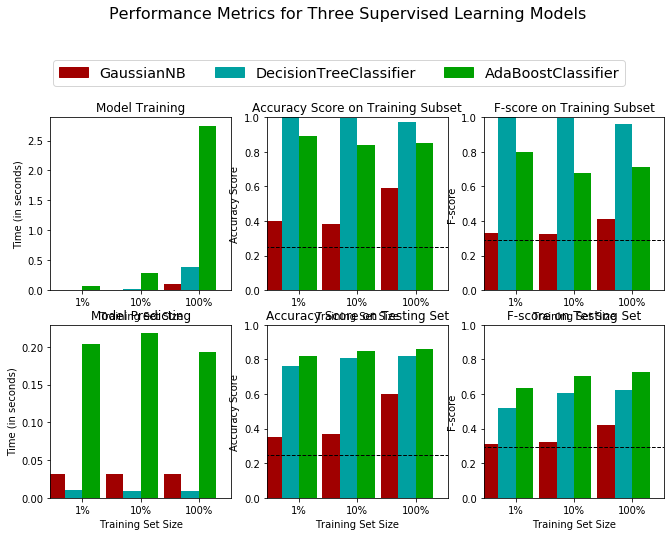

In [12]:
# Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Initialize the three models
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier(random_state=1)
clf_C = AdaBoostClassifier(random_state=1)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# samples_100 is the entire training set i.e. len(y_train)
# samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(len(y_train) * 0.1)
samples_1 = int(len(y_train) * 0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

---
## Improving Results
Choose from the three supervised learning models the *best* model to use on the student data. Then, perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score.

### Q3 - Choosing the Best Model
- Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than 50k.

In [13]:
print('--------------------------------------------------------')
for i in results.items():
    print('\t\t'+i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1% of Training Set', 1:'10% of Training Set', 2:'Entire Training Set'}))
    print('--------------------------------------------------------')

--------------------------------------------------------
		GaussianNB


,1% of Training Set,10% of Training Set,Entire Training Set
train_time,0.001995,0.008976,0.101721
pred_time,0.031941,0.031915,0.031917
acc_train,0.400000,0.383333,0.593333
acc_test,0.351797,0.366059,0.597678
f_train,0.333333,0.325092,0.412500
f_test,0.310134,0.320258,0.420899


--------------------------------------------------------
		DecisionTreeClassifier


,1% of Training Set,10% of Training Set,Entire Training Set
train_time,0.005976,0.025898,0.394953
pred_time,0.009953,0.009009,0.008970
acc_train,1.000000,0.996667,0.970000
acc_test,0.761968,0.807186,0.817689
f_train,1.000000,0.997191,0.963855
f_test,0.519912,0.604928,0.626101


--------------------------------------------------------
		AdaBoostClassifier


,1% of Training Set,10% of Training Set,Entire Training Set
train_time,0.071809,0.294211,2.750615
pred_time,0.204479,0.218417,0.193516
acc_train,0.893333,0.840000,0.850000
acc_test,0.820674,0.849862,0.857601
f_train,0.801282,0.680147,0.711538
f_test,0.632757,0.701882,0.724551


--------------------------------------------------------


Among all the 3 learning models, **AdaBoost** seems to be the best choice primarily for the following reasons:

- Among all the models used, AdaBoost has the highest accuracy as well as F-score on the testing set when used across all sample sizes of the training data(i.e. 1%, 10% as well as 100%).
- Decision Tree's training accuracy and F-score is almost a perfect 1, which means it's overfitting the data. This is something we definitely want to avoid. Coming to the remaining 2 models, AdaBoost has a much better accuracy and F-score compared to Gaussian Naive Bayes. It does understandably well across all training set sizes and doesn't shows signs of overfitting.
- It's evident from the above visualization that Adaboost takes the highest predicting/training time among all the models. However, its prediction time reduces drastically when compared to its training time.
- On drilling down further, AdaBoost takes a second more to train & approx. 0.03 seconds more to test compared to the next best classifier, when 100% of the training set is used. These time differences are relatively nominal & AdaBoost's advantages (listed above) over the other classifiers outweighs them considerably.
- AdaBoost works by creating a highly accurate classifier by combining many relatively weak and inaccurate classifiers. It is known to be a powerful classifier and the above metrics support this theory, too.

### Q4 - Describing the model in Layman's Terms
- In one to two paragraphs, explain to CharityML, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction.

First, let’s go over some basic terminologies.

**Boosting**: combining many weak (simple) learners to create a highly accurate prediction.

**Weak learners**: classifiers that produce prediction that is slightly better than random guessing. Random guessing is equivalent to 50%, like flipping a coin.

**AdaBoost (Adaptive Boosting)**, the first practical boosting algorithm, is a powerful classifier that works well on both basic and more complex problems. AdaBoost works by creating a highly accurate classifier by combining many relatively weak and inaccurate classifiers. AdaBoost therefore acts as a meta algorithm, which allows you to use it as a wrapper for other classifiers. AdaBoost is adaptive in the sense that subsequent classifiers added at each round of boosting are tweaked in favor of those instances misclassified by previous classifiers.

Simply put, the idea is to set weights to both classifiers and data points (samples) in a way that forces classifiers to concentrate on observations that are difficult to correctly classify. This process is done sequentially in that the two weights are adjusted at each step as iterations of the algorithm proceed. This is why Adaboost is referred to as a sequential ensemble method — ensemble referring to a type of learning that combines several models to improve the final predictive performance.

---
### Model Tuning
Fine tune the chosen model. Use grid search (GridSearchCV) with at least one important parameter tuned with at least 3 different values.

In [ ]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

# Initialize the classifier
clf = AdaBoostClassifier(random_state=1)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {
    'n_estimators': [50, 100, 125, 150],
    'learning_rate': [0.1, 0.5, 1.0, 1.5]
}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

### Q5 - Final Model Evaluation
- What is your optimized model's accuracy and F-score on the testing data?
- Are these scores better or worse than the unoptimized model?
- How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in Question 1?



The optimized model's accuracy and F-score on the testing data is 0.8645 and 0.7375 respectively, which is slightly better than the unoptimized model. However, the scores of the optimized model are significantly better compared to the naive predictor benchmarks.

---

## Feature Importance
An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than 50k .

### Q6 - Feature relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

1. `'capital-gain'`: Capital gain provides a very good understanding of an individual's financial status. In other words, an individual with higher capital gain is more likely to have a very good income which enables him/her to save and invest more regularly as compared to an individual with little or zero capital gain.

2. `'education_level'`: Specialized/niche/senior level jobs tend to pay higher salaries. An individual with a higher level of education is more likely to have such a job and therefore, a better income.

3. `'age'`: Age can be a criterion in determining an individual's seniority level as well as years of service. And, both these factors can affect the income.

4. `'occupation'`: Occupation plays an important role in determining pay scales. Some occupation requires better skill level and therefore, a better income.

5. `'hours-per-week'`: A lot of jobs offer salaries based on the hours an individual put in every week. So, it is safe to assume that more hours per week can result in a higher income.

### Extracting Feature Importance

In [ ]:
# Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier().fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Q7 - Extracting Feature Importance
Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above 50k.

- How do these five features compare to the five features you discussed in Question 6?
- If you were close to the same answer, how does this visualization confirm your thoughts?
- If you were not close, why do you think these features are more relevant?

My list of 5 important features is missing `'capital-loss'` and `'education-num'`. Moreover, the ranking of my features is a bit different from the above visualization. For example, I considered capital-gain as the most important feature whereas the visualization shows capital-loss as the most important one. Age and hours-per-week ranked 3rd and last in my list; whereas, they are ranked 2nd and 4th in the above visualization.

Having said that, I think my features selection is pretty close. The reason being education-num (which is one of the 2 features that I didn't consider) and education_level (the one I considered and the visualization didn't) can be used interchangeably. According to our data, most of the individuals with similar education levels have similar education-num. To name a few, individuals having education_level as 7th-8th, 9th, 11th and HS-grad have education-num as 4.0, 5.0, 7.0 and 9.0 respectively.

I think, education-num, being a numerical feature, is probably preferred more and that's why it's selected over education_level. And as far as capital-loss is concerned, I didn't include it because I thought that capital-gain will prove very useful to determine whether an individual's income > 50K. But, now when I think of it, capital-loss will help us immensely as a higher capital-loss means an individual's income is probably less than 50K and vice-versa.

### Feature Selection
With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of all features present in the data. This hints that we can attempt to reduce the feature space and simplify the information required for the model to learn.

In [ ]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

### Q8 - Effects of Feature Selection
- How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
- If training time was a factor, would you consider using the reduced data as your training set?

The final model trained on reduced data has an accuracy score lower by 3% and a F-score lower by 5% compared to the one trained on full data. I would say that the dip in accuracy score isn't much of a bother but the dip in F-score seems significant.

If a lot of training points were to be processed and training time was a factor, I would consider the reduced data as my training set. Having said that, if F-score was a lot more important than the accuracy score, I would definitely take a closer look before making any decision.